In [424]:
#Libraries for env
import time
import datetime
from datetime import date
import folium

#Main libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler


#Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import load_sample_image
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

#Viz
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Video

In [24]:
uber_df=pd.read_csv('uber-raw-data-apr14.csv')
lyft_df=pd.read_csv('Lyft_B02510.csv')

# 1. Data exploration

Let's explore data in **Uber**:

In [25]:
uber_df

Date/Time      Lat      Lon    Base
0         4/1/2014 0:11:00  40.7690 -73.9549  B02512
1         4/1/2014 0:17:00  40.7267 -74.0345  B02512
2         4/1/2014 0:21:00  40.7316 -73.9873  B02512
3         4/1/2014 0:28:00  40.7588 -73.9776  B02512
4         4/1/2014 0:33:00  40.7594 -73.9722  B02512
...                    ...      ...      ...     ...
564511  4/30/2014 23:22:00  40.7640 -73.9744  B02764
564512  4/30/2014 23:26:00  40.7629 -73.9672  B02764
564513  4/30/2014 23:31:00  40.7443 -73.9889  B02764
564514  4/30/2014 23:32:00  40.6756 -73.9405  B02764
564515  4/30/2014 23:48:00  40.6880 -73.9608  B02764

[564516 rows x 4 columns]

Let's explore data in **Lyft**:

In [26]:
lyft_df

time_of_trip  start_lat  start_lng Unnamed: 3
0         9/4/2014 9:51   40.64705  -73.77988        NaN
1       8/27/2014 21:13   40.74916  -73.98373        NaN
2        9/4/2014 14:16   40.64065  -73.97594        NaN
3        9/4/2014 16:08   40.75002  -73.99514        NaN
4        8/28/2014 2:41   40.76715  -73.98636        NaN
...                 ...        ...        ...        ...
267696    9/7/2014 3:19   40.71931  -73.99138        NaN
267697    9/7/2014 2:59   40.73868  -73.98862        NaN
267698    9/7/2014 1:55   40.71554  -73.94877        NaN
267699   9/5/2014 23:26   40.74667  -73.97445        NaN
267700   9/6/2014 22:19   40.74393  -73.78011        NaN

[267701 rows x 4 columns]

In [27]:
lyft_df['Unnamed: 3'].isna().sum()

266503

It seems we have many Nan in this column. 

To look inside, first filling with strings.

In [28]:
lyft_df['Unnamed: 3'].fillna('unknown', inplace=True)

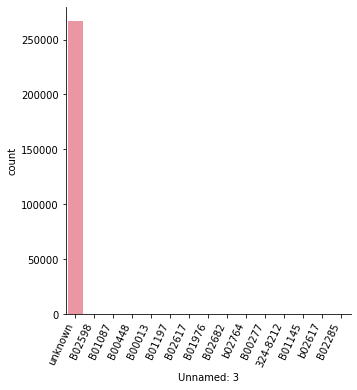

In [29]:
figure1=sns.catplot(x='Unnamed: 3', data=lyft_df, kind='count')
figure1.set_xticklabels(rotation=65, horizontalalignment='right')

It seems we shouldn't concern much on this column. Let's drop this column.

In [30]:
lyft_df.drop(columns=['Unnamed: 3'], inplace=True)

In [31]:
lyft_df

time_of_trip  start_lat  start_lng
0         9/4/2014 9:51   40.64705  -73.77988
1       8/27/2014 21:13   40.74916  -73.98373
2        9/4/2014 14:16   40.64065  -73.97594
3        9/4/2014 16:08   40.75002  -73.99514
4        8/28/2014 2:41   40.76715  -73.98636
...                 ...        ...        ...
267696    9/7/2014 3:19   40.71931  -73.99138
267697    9/7/2014 2:59   40.73868  -73.98862
267698    9/7/2014 1:55   40.71554  -73.94877
267699   9/5/2014 23:26   40.74667  -73.97445
267700   9/6/2014 22:19   40.74393  -73.78011

[267701 rows x 3 columns]

**Uber**

Let's see in timeline exploration in Uber:

In [52]:
uber_df['Date/Time'] = pd.to_datetime(uber_df['Date/Time'], format="%m/%d/%Y %H:%M:%S")
uber_df['DayOfWeekNum'] = uber_df['Date/Time'].dt.dayofweek
uber_df['DayOfWeek'] = uber_df['Date/Time'].dt.day_name()
uber_df['MonthDayNum'] = uber_df['Date/Time'].dt.day
uber_df['HourOfDay'] = uber_df['Date/Time'].dt.hour
uber_df['MinOfDay'] = uber_df['Date/Time'].dt.minute
uber_df.head()

Date/Time      Lat      Lon    Base  DayOfWeekNum DayOfWeek  \
0 2014-04-01 00:11:00  40.7690 -73.9549  B02512             1   Tuesday   
1 2014-04-01 00:17:00  40.7267 -74.0345  B02512             1   Tuesday   
2 2014-04-01 00:21:00  40.7316 -73.9873  B02512             1   Tuesday   
3 2014-04-01 00:28:00  40.7588 -73.9776  B02512             1   Tuesday   
4 2014-04-01 00:33:00  40.7594 -73.9722  B02512             1   Tuesday   

   MonthDayNum  HourOfDay  MinOfDay  
0            1          0        11  
1            1          0        17  
2            1          0        21  
3            1          0        28  
4            1          0        33

Let's see difference in day(Uber)

In [72]:
df_1_uber=pd.DataFrame(uber_df.groupby('DayOfWeek')['Lat'].count())
df_1_uber['DayOfWeek']=df_1_uber.index
df_1_uber

Lat  DayOfWeek
DayOfWeek                   
Friday      90303     Friday
Monday      60861     Monday
Saturday    77218   Saturday
Sunday      51251     Sunday
Thursday    85067   Thursday
Tuesday     91185    Tuesday
Wednesday  108631  Wednesday

In [83]:
df_2_uber=pd.DataFrame(uber_df.groupby('HourOfDay')['Lat'].count())
df_2_uber['HourOfDay']=df_2_uber.index

Text(0.5, 6.79999999999999, 'Uber')

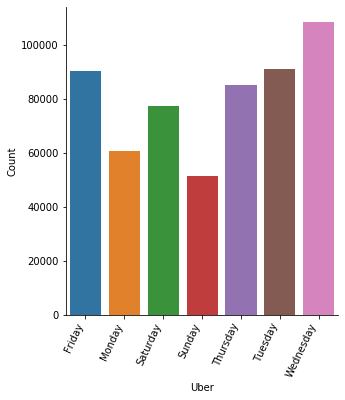

In [84]:
figure=sns.catplot(x='DayOfWeek', y='Lat', data=df_1_uber, kind='bar')
figure.set_xticklabels(rotation=65, horizontalalignment='right')
plt.ylabel('Count')
plt.xlabel('Uber')

It seems that Wednesday is the most busy day in April (Uber).

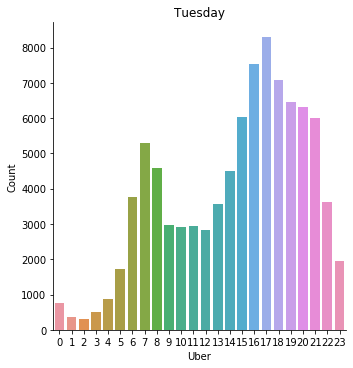

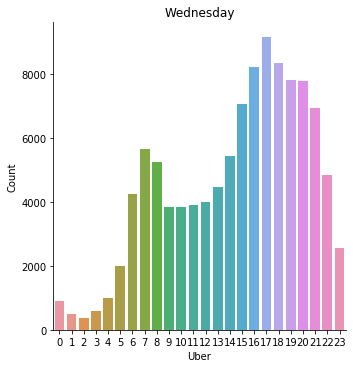

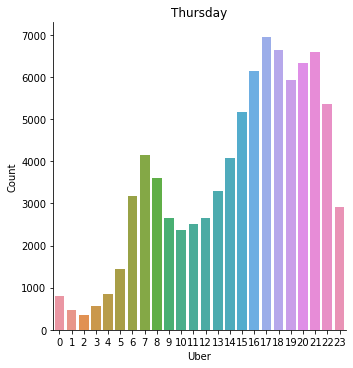

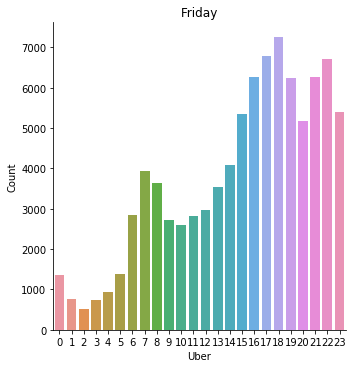

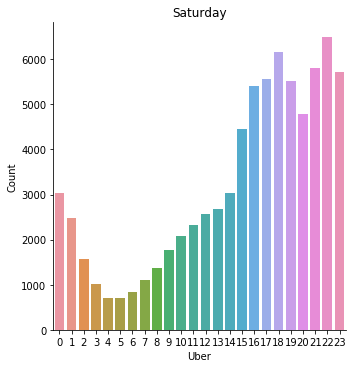

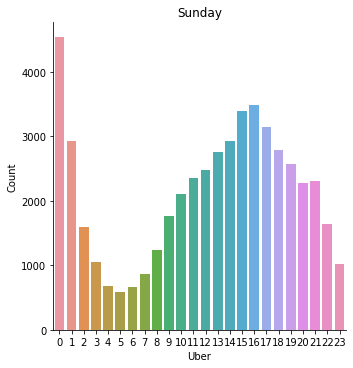

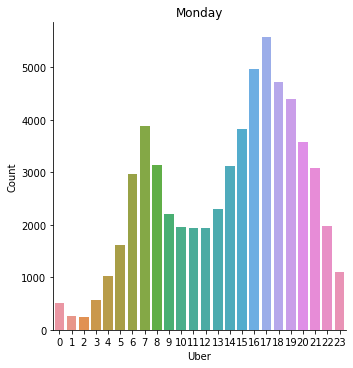

In [96]:
for i in uber_df['DayOfWeek'].unique():
    mask_uber=uber_df['DayOfWeek']==i
    df_3_uber=pd.DataFrame(uber_df[mask_uber].groupby('HourOfDay')['Lat'].count())
    df_3_uber['HourOfDay']=df_3_uber.index
    figure=sns.catplot(x='HourOfDay', y='Lat', data=df_3_uber, kind='bar')
    plt.title(i)
    plt.ylabel('Count')
    plt.xlabel('Uber')
    plt.show()

This shows that Uber is busiest in Wednesday 17h-20h. Also Saturday night and Sunday morning(which is still Saturday night) unusually (comparing to other nights) a lot passengers.


**Lyft**

Let's see in timeline exploration in Lyft:

In [37]:
lyft_df['time_of_trip'] = pd.to_datetime(lyft_df['time_of_trip'], format="%m/%d/%Y %H:%M")
lyft_df['DayOfWeekNum'] = lyft_df['time_of_trip'].dt.dayofweek
lyft_df['DayOfWeek'] = lyft_df['time_of_trip'].dt.day_name()
lyft_df['MonthDayNum'] = lyft_df['time_of_trip'].dt.day
lyft_df['HourOfDay'] = lyft_df['time_of_trip'].dt.hour
lyft_df['MinOfDay'] = lyft_df['time_of_trip'].dt.minute
lyft_df.head()

time_of_trip  start_lat  start_lng  DayOfWeekNum  DayOfWeek  \
0 2014-09-04 09:51:00   40.64705  -73.77988             3   Thursday   
1 2014-08-27 21:13:00   40.74916  -73.98373             2  Wednesday   
2 2014-09-04 14:16:00   40.64065  -73.97594             3   Thursday   
3 2014-09-04 16:08:00   40.75002  -73.99514             3   Thursday   
4 2014-08-28 02:41:00   40.76715  -73.98636             3   Thursday   

   MonthDayNum  HourOfDay  MinOfDay  
0            4          9        51  
1           27         21        13  
2            4         14        16  
3            4         16         8  
4           28          2        41

In [38]:
#Let's change 'start_lat', 'start_lng' same as Uber.
lyft_df.rename(columns={"start_lat":"Lat", "start_lng": "Lon"}, errors="raise", inplace=True)

#We wouldn't need time_of_trip
# lyft_df.drop(columns=['time_of_trip'], inplace=True)

In [39]:
lyft_df

time_of_trip       Lat       Lon  DayOfWeekNum  DayOfWeek  \
0      2014-09-04 09:51:00  40.64705 -73.77988             3   Thursday   
1      2014-08-27 21:13:00  40.74916 -73.98373             2  Wednesday   
2      2014-09-04 14:16:00  40.64065 -73.97594             3   Thursday   
3      2014-09-04 16:08:00  40.75002 -73.99514             3   Thursday   
4      2014-08-28 02:41:00  40.76715 -73.98636             3   Thursday   
...                    ...       ...       ...           ...        ...   
267696 2014-09-07 03:19:00  40.71931 -73.99138             6     Sunday   
267697 2014-09-07 02:59:00  40.73868 -73.98862             6     Sunday   
267698 2014-09-07 01:55:00  40.71554 -73.94877             6     Sunday   
267699 2014-09-05 23:26:00  40.74667 -73.97445             4     Friday   
267700 2014-09-06 22:19:00  40.74393 -73.78011             5   Saturday   

        MonthDayNum  HourOfDay  MinOfDay  
0                 4          9        51  
1                27         21        13  
2                 4         14        16  
3                 4         16         8  
4                28          2        41  
...             ...        ...       ...  
267696            7          3        19  
267697            7          2        59  
267698            7          1        55  
267699            5         23        26  
267700            6         22        19  

[267701 rows x 8 columns]

Text(0.5, 6.79999999999999, 'Lyft')

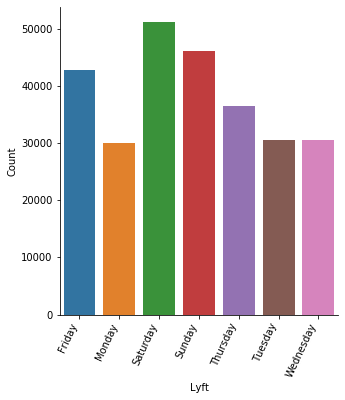

In [40]:
df_1_lyft=pd.DataFrame(lyft_df.groupby('DayOfWeek')['Lat'].count())
df_1_lyft['DayOfWeek']=df_1_lyft.index
df_2_lyft=pd.DataFrame(lyft_df.groupby('HourOfDay')['Lat'].count())
df_2_lyft['HourOfDay']=df_2_lyft.index
figure=sns.catplot(x='DayOfWeek', y='Lat', data=df_1_lyft, kind='bar')
figure.set_xticklabels(rotation=65, horizontalalignment='right')
plt.ylabel('Count')
plt.xlabel('Lyft')

It seems most busy day is Saturday for Lyft.

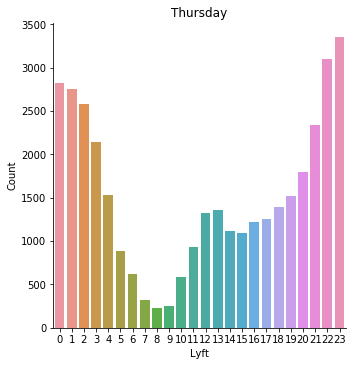

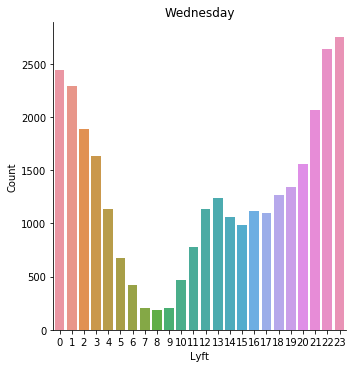

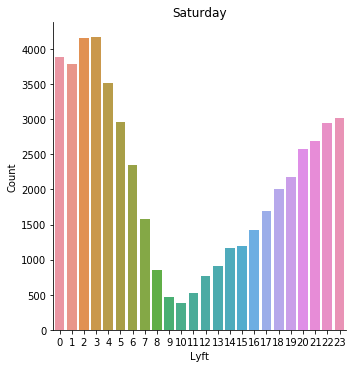

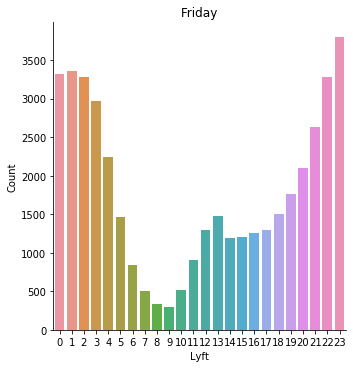

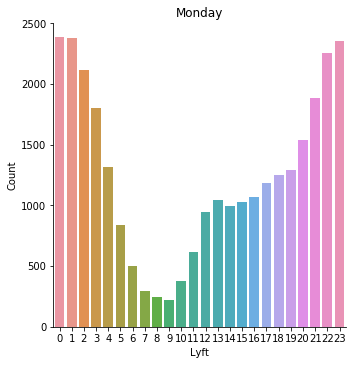

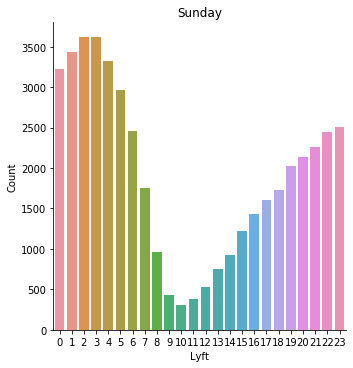

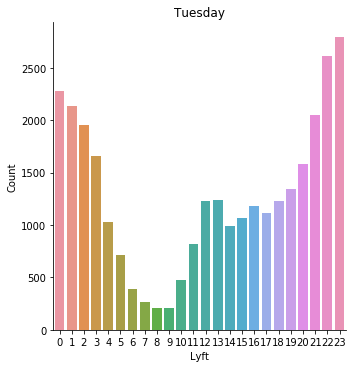

In [44]:
for i in lyft_df['DayOfWeek'].unique():
    mask_lyft=lyft_df['DayOfWeek']==i
    df_3_lyft=pd.DataFrame(lyft_df[mask_lyft].groupby('HourOfDay')['Lat'].count())
    df_3_lyft['HourOfDay']=df_3_lyft.index
    figure=sns.catplot(x='HourOfDay', y='Lat', data=df_3_lyft, kind='bar')
    plt.title(i)
    plt.ylabel('Count')
    plt.xlabel('Lyft')
    plt.show()

# 2.1. K-Means

**Uber**


Let's see Elbow Method.

In [21]:
X_uber=uber_df[['Lat','Lon']]
X_uber

Lat      Lon
0       40.7690 -73.9549
1       40.7267 -74.0345
2       40.7316 -73.9873
3       40.7588 -73.9776
4       40.7594 -73.9722
...         ...      ...
564511  40.7640 -73.9744
564512  40.7629 -73.9672
564513  40.7443 -73.9889
564514  40.6756 -73.9405
564515  40.6880 -73.9608

[564516 rows x 2 columns]

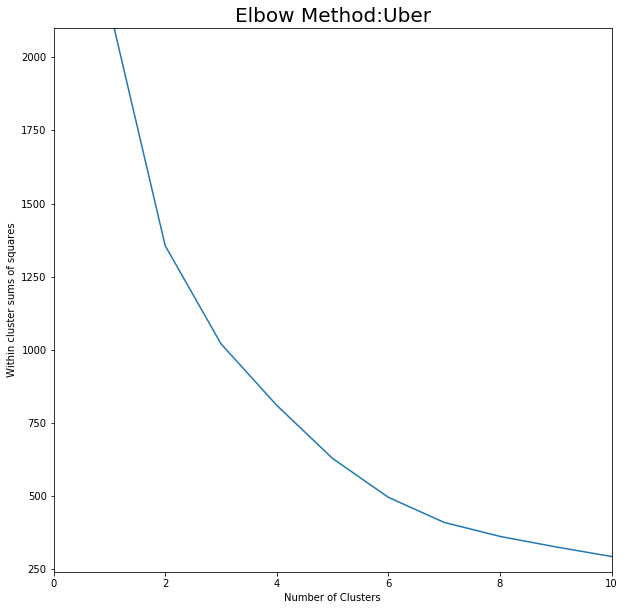

In [307]:
#Seeing Elbow method to find cluster number

within_cluster_sums_of_squares_uber = []

for i in range(1, 11):
    km_uber = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km_uber.fit(X_uber)
    within_cluster_sums_of_squares_uber.append(km_uber.inertia_)

f,ax = plt.subplots(figsize=(10,10))
ax.set(xlim=(0, 10), ylim=(240, 2100))
plt.plot(range(1, 11), within_cluster_sums_of_squares_uber)
plt.title('Elbow Method:Uber', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('Within cluster sums of squares')
plt.show()

It seems cluster 4 or 5 or 6 works fine.

Let's see on Silhuette method:(using scikit learn code)
I set between 2-7 clusters. Because as we can see Elbow method plot, no need to see above 9.

I wanted to plot Silhouette plot, but my Kernel dies everytime I run. In this case, we can find just coefficients. And compare it with K-means Elbow method.

In [ ]:
print(__doc__)

X_uber=X_uber.values

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_uber)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_uber, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

Let's use cluster 6

In [7]:
# #Normalizing
# sc= StandardScaler()
# X_uber = pd.DataFrame(sc.fit_transform(X_uber), columns=X_uber.columns)
# X_uber

Lat       Lon
0       0.803554  0.434636
1      -0.368737 -1.143922
2      -0.232940 -0.207893
3       0.520874 -0.015531
4       0.537502  0.091557
...          ...       ...
564511  0.664986  0.047929
564512  0.634501  0.190713
564513  0.119025 -0.239623
564514 -1.784910  0.720204
564515 -1.441259  0.317632

[564516 rows x 2 columns]

In [157]:
#Running classifier for 6 clusters
km_uber_c = KMeans(n_clusters = 6, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
km_uber_c.fit(X_uber)

KMeans(n_clusters=6, random_state=0)

In [158]:
#Find centroids:
centroids_uber=km_uber_c.cluster_centers_
#Assign into dataframe
centroids_df_uber=pd.DataFrame(centroids_uber, columns=['Lat_u','Lon_u'])

In [159]:
centroids_df_uber

Lat_u      Lon_u
0  40.765606 -73.972802
1  40.688618 -73.965579
2  40.659521 -73.773996
3  40.797922 -73.868883
4  40.700541 -74.201673
5  40.731169 -73.998582

Plotting these centroids in 2 dimension would no relevent meaning, I will show these centroids in NY map using Google map:
    

In [160]:
# Centroids to lists
centroids_df_uber = centroids_df_uber.values.tolist()

In [161]:
# Ploting the centroids on map
map = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',)

for i in range(0, len(centroids_df_uber)):
    folium.Marker(centroids_df_uber[i], popup = centroids_df_uber[i]).add_to(map)
map

# 2.2. DBSCAN

Let's find density on map with DBSCAN.

First we need to find out best parameter for our clustering. 
I will find best esp according to https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
    

In [ ]:
#Find N-neighbors:

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_uber)
distances, indices = nbrs.kneighbors(X_uber)


#Plotting esp curve to find most curving point
#The data was big, we had to zoom in.

f,ax = plt.subplots(figsize=(20,20))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
ax.set(xlim=(540000, 560000), ylim=(0.0, 0.0015))
plt.plot(distances)
plt.show()

In [489]:
#Find N-neighbors:

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_uber)
distances, indices = nbrs.kneighbors(X_uber)

In [ ]:
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]
# plt.plot(distances)

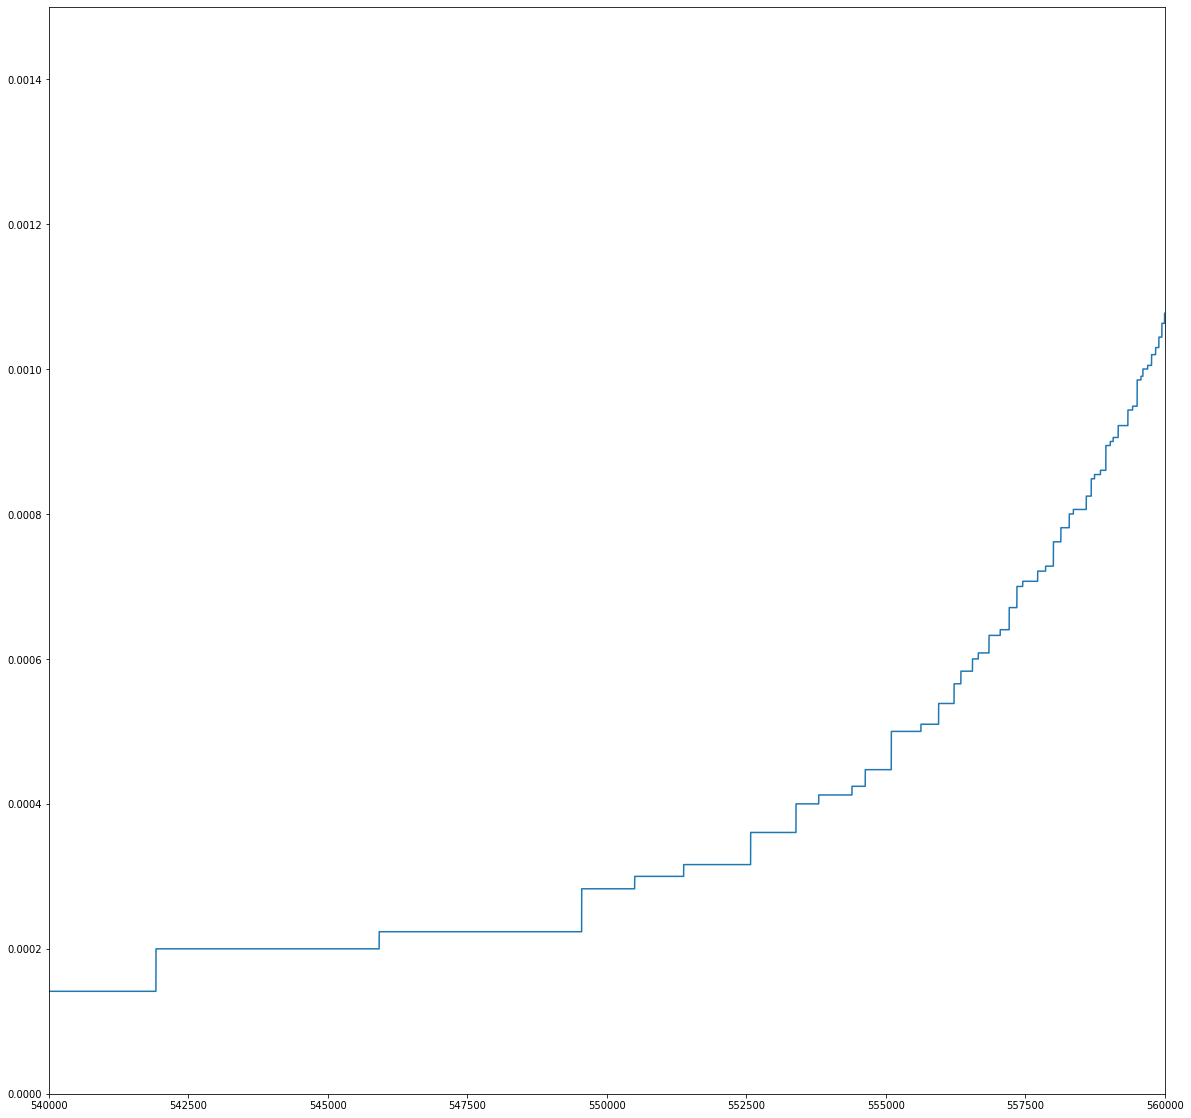

In [71]:
#Plotting esp curve to find most curving point
#The data was big, we had to zoom in.

f,ax = plt.subplots(figsize=(20,20))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
ax.set(xlim=(540000, 560000), ylim=(0.0, 0.0015))
plt.plot(distances)
plt.show()

In [ ]:
#Let's cluster with DBSCAN

db_uber = DBSCAN(eps = 0.00028, min_samples = 10000, algorithm='ball_tree', metric='haversine')

db_uber.fit(np.radians(X_uber))
cluster_labels = db_uber.labels_
num_clusters = len(set(cluster_labels))

**Whenever I try to run this ↑↑↑ my Kernel dies.**

 It seems that in my environment (Jupiter w Anaconda) K-Means is best for our data. Let's change the approach.

 We can see density movement just for one day, not for whole day. Let's see again our weekdays. We will choose Wednesday as a most dynamic day. Because we can see here that max passengers 8k, and min is 261. Let's see how density moves during 24h timelaps.

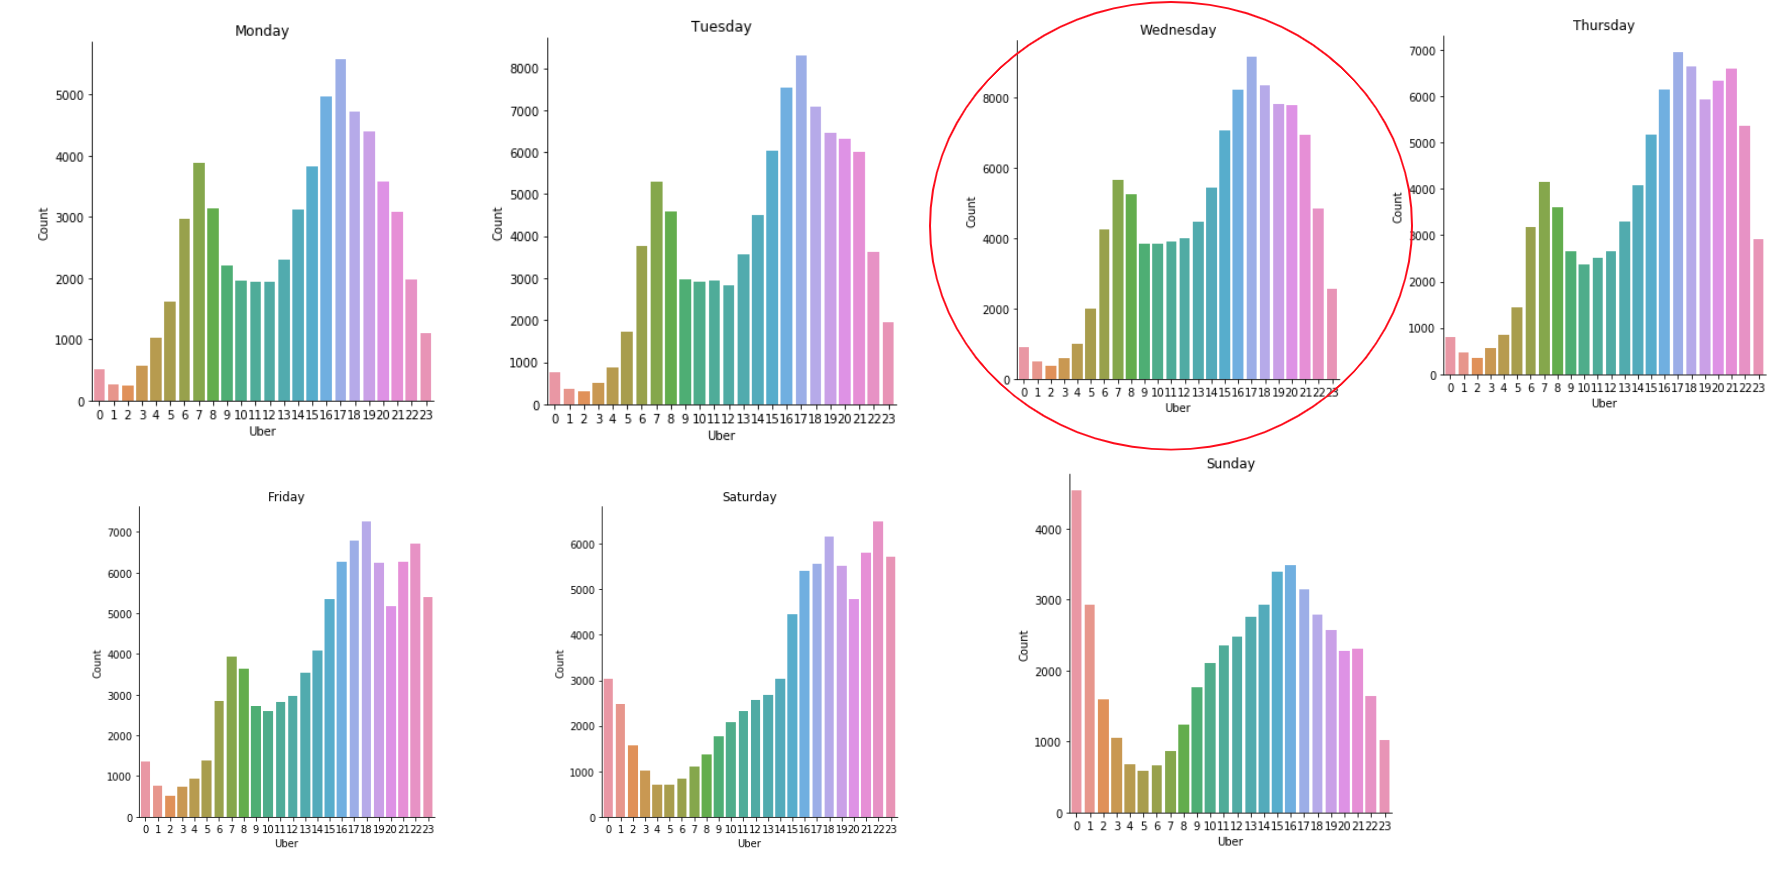

In [288]:
#First,let's calculate 24h(Wednesday) trips

mask_uber_wed=((uber_df['DayOfWeek']=='Wednesday') & (uber_df['HourOfDay']==0))

df_uber_wed_latlon_0=pd.DataFrame(uber_df[mask_uber_wed][['Lat','Lon']])
df_uber_wed_latlon_0

Lat      Lon
1011    40.7458 -73.9843
1012    40.7285 -74.0467
1013    40.7732 -73.9546
1014    40.6550 -73.9786
1015    40.7405 -74.0040
...         ...      ...
559481  40.6821 -74.0041
561468  40.7236 -73.9972
563910  40.7318 -73.9838
563911  40.6878 -74.1819
563912  40.7738 -73.8717

[899 rows x 2 columns]

In [289]:
#Clustering with only Wednesday data

db_uber_0 = DBSCAN(eps = 0.00028, min_samples = 20, algorithm='ball_tree', metric='haversine')

db_uber_0.fit(np.radians(df_uber_wed_latlon_0))
cluster_labels = db_uber_0.labels_
num_clusters = len(set(cluster_labels))

In [291]:
num_clusters

4

We got 4 clusters!

In [294]:
#Predicting DBSCAN

dbscan_predict = db_uber_0.fit_predict(df_uber_wed_latlon_0)

In [297]:
#Add Labels column for plotting

df_uber_wed_latlon_0['Labels']=dbscan_predict

In [298]:
df_uber_wed_latlon_0

Lat      Lon  Labels
1011    40.7458 -73.9843      -1
1012    40.7285 -74.0467      -1
1013    40.7732 -73.9546      -1
1014    40.6550 -73.9786      -1
1015    40.7405 -74.0040      -1
...         ...      ...     ...
559481  40.6821 -74.0041      -1
561468  40.7236 -73.9972      -1
563910  40.7318 -73.9838      -1
563911  40.6878 -74.1819      -1
563912  40.7738 -73.8717      -1

[899 rows x 3 columns]

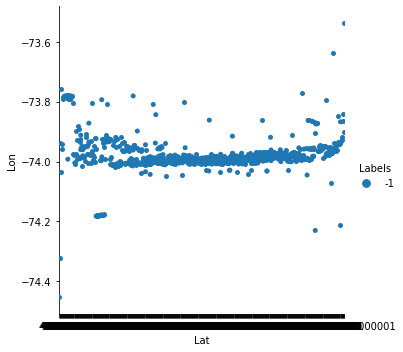

In [128]:
#Let's plot the Wednesday data with clusters:

sns.catplot(x='Lat', y='Lon',data=df_uber_wed_latlon_0, hue='Labels')

It seems DBSCAN is heavy and not working at all ^^;
Let's go back to the K-means and calculate density with clustering.

# 2.3. Back to the K-means

In [301]:
#We don't need Labels column for K-means. Let's drop it:
df_uber_wed_latlon_0.drop(columns=['Labels'], inplace=True)

507 trips were in NY.

In [317]:
#Finding how many trips were at 01am:
i=1
df_every_hour=uber_df[(uber_df['DayOfWeek']=='Wednesday') & (uber_df['HourOfDay']==i)][['Lat','Lon']]
df_every_hour

Lat      Lon
1020    40.7218 -73.9580
1021    40.7332 -73.9935
1022    40.7208 -73.9841
1023    40.7593 -73.9722
10193   40.7608 -73.9782
...         ...      ...
554935  40.7121 -73.9572
554936  40.7643 -73.9909
559482  40.7233 -73.9957
561469  40.7509 -74.0040
563913  40.7615 -73.9996

[507 rows x 2 columns]

In [319]:
#Running K-means with 4 clusters
km_every_hour = KMeans(n_clusters = 4, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0).fit(df_every_hour)


In [320]:
#Finding y
y_every_hour = km_every_hour.fit_predict(df_every_hour)
# y_0 = pd.DataFrame(y_kmeans_0)

In [322]:
#Find centroids:
centroids_ever_hour=km_every_hour.cluster_centers_km_every_hour
#Assign into dataframe
centroids_ever_hour=pd.DataFrame(centroids_ever_hour, columns=['Lat_u_0','Lon_u_0'])

In [323]:
# Centroids to lists
centroids_ever_hour = centroids_ever_hour.values.tolist()

In [383]:
centroids_ever_hour

array([[ 40.729319  , -74.00015092],
       [ 40.65048723, -73.78125532],
       [ 40.70007381, -74.19543095],
       [ 40.76142643, -73.97893965],
       [ 40.79398261, -73.88225761],
       [ 40.6924214 , -73.96010545]])

In [325]:
#Ploting the centroids on map
#with normal map
map_every_hour = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap', zoom_start=9)

for i in range(0, len(centroids_ever_hour)):
    folium.Marker(centroids_ever_hour[i], popup = centroids_ever_hour[i]).add_to(map_every_hour)
map_every_hour

In [264]:
centroids_df_uber_0[0]

[40.80332068965517, -73.85681724137932]

Finding clusters at 0 am on Wednesday.

In [481]:
#Mask for data Wed
df_kmeans_wed=pd.DataFrame(uber_df[uber_df['DayOfWeek']=='Wednesday'][['Lat','Lon']])

In [482]:
#K-means for Wed
km_wed = KMeans(n_clusters = 6, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0).fit(df_kmeans_wed)
#Find y
y_kmeans_wed = km_wed.fit_predict(df_kmeans_wed)
#Centroids
centroids_wed=km_wed.cluster_centers_

In [487]:
# Ploting the 6 clusters and classes from prediction on map on Wednesday

color_u=['#CE4A7EFF','blue','yellow','cyan','#008C76FF','#FC766AFF']

folium_map_km=folium.Map(location=[40.767937,-73.982155 ],tiles='cartodbdark_matter', zoom_start=12)

for i in range(len(centroids_wed)):
    for j in range(len(df_kmeans_wed[y_kmeans_wed == i])):
        folium.CircleMarker([df_kmeans_wed['Lat'][y_kmeans_wed == i].iloc[j], df_kmeans_wed['Lon'][y_kmeans_wed == i].iloc[j]],
                            radius=3,
                            color=color_u[i],
                            fill=True
                            ).add_to(folium_map_km)

#Plotting Centroid points on map
for k in range(len(centroids_wed)):
        folium.CircleMarker(centroids_wed[k],
                            radius=9,
                            color='red',
                            fill_color='red',
                            fill=True
                            ).add_to(folium_map_km)


In [485]:
folium_map_km.save("Kmeans_Wed.html")

In [379]:
# Ploting the 6 clusters and classes from prediction on map EVERY HOUR

hours24=24

#Colors for trips
color_u=['#CE4A7EFF','blue','green','#B0BFED','#008C76FF','#FC766AFF']

#Initiliazing the map with dark mode
folium_map_every_hour=folium.Map(location=[40.767937,-73.982155 ],
                                 tiles='cartodbdark_matter', 
                                 zoom_start=10)

#Loop for every hour
for i in range(hours24):
    #Initiliaze the map
    folium_map_every_hour=folium.Map(location=[40.767937,-73.982155 ],tiles='cartodbdark_matter', zoom_start=11)
    
    #Finding Lat and Lon information for every hour 
    df_every_hour=uber_df[(uber_df['DayOfWeek']=='Wednesday') & (uber_df['HourOfDay']==i)][['Lat','Lon']]
    #Cluster K-Means for every hour
    km_every_hour = KMeans(n_clusters = 6, init = "k-means++", 
                           max_iter = 300, n_init = 10, 
                           random_state = 42).fit(df_every_hour)
    #Finding y for every hour
    y_every_hour = km_every_hour.fit_predict(df_every_hour)
    #Finding centroids for every hour
    centroids_ever_hour=km_every_hour.cluster_centers_
    
    #Loop for getting each trip on map
    for j in range(0, len(centroids_ever_hour)): #Loop for 6 cluster (6 times)
        for k in range(len(df_every_hour[y_every_hour == j])): #In each trip it's different depends on density
            folium.CircleMarker([df_every_hour['Lat'][y_every_hour == j].iloc[k], #lattitude
                                 df_every_hour['Lon'][y_every_hour == j].iloc[k]],#longtitude
                                radius=3,
                                color=color_u[j],
                                fill=True
                                ).add_to(folium_map_every_hour)

    #Plotting Centroid points on map
    for centroid in range(0, len(centroids_ever_hour)): #Loop for 6 cluster (6 times)
        folium.CircleMarker(centroids_ever_hour[centroid],
                            radius=9,
                            color='orange',
                            fill_color='orange',
                            fill=True,
                            fill_opacity=0.8
                            ).add_to(folium_map_every_hour)
    #Saving as HTML
    folium_map_every_hour.save("Uber_{0}h.html".format(i))
    #Saved 24 HTML pages and used gif maker to get gif.

#Show the map
folium_map_every_hour

**We can see in Manhatten many trips were made. And other clusters are near the airports.**

In [381]:
Video("Uber-24h.mp4")

In this gif, we can see near the airport there is much more movement comparing to Manhattan center.

# 2.4. Trying again DBSCAN (Never give up!)

Let's use DBSCAN for clustering same Wednesday data.

In [472]:
#Data of Wednesday (24h)

df_dbscan_wed=pd.DataFrame(uber_df[uber_df['DayOfWeek']=='Wednesday'][['Lat','Lon']])
df_dbscan_wed

Lat      Lon
1011    40.7458 -73.9843
1012    40.7285 -74.0467
1013    40.7732 -73.9546
1014    40.6550 -73.9786
1015    40.7405 -74.0040
...         ...      ...
564511  40.7640 -73.9744
564512  40.7629 -73.9672
564513  40.7443 -73.9889
564514  40.6756 -73.9405
564515  40.6880 -73.9608

[108631 rows x 2 columns]

1. First let's use NearestNeighbors method to optimal best eps parameter

In [414]:
#Find N-neighbors:

neigh_dbscan = NearestNeighbors(n_neighbors=2) 
nbrs_dbscan = neigh_dbscan.fit(df_dbscan_wed)
distances_dbscan, indices_dbscan = nbrs_dbscan.kneighbors(df_dbscan_wed)

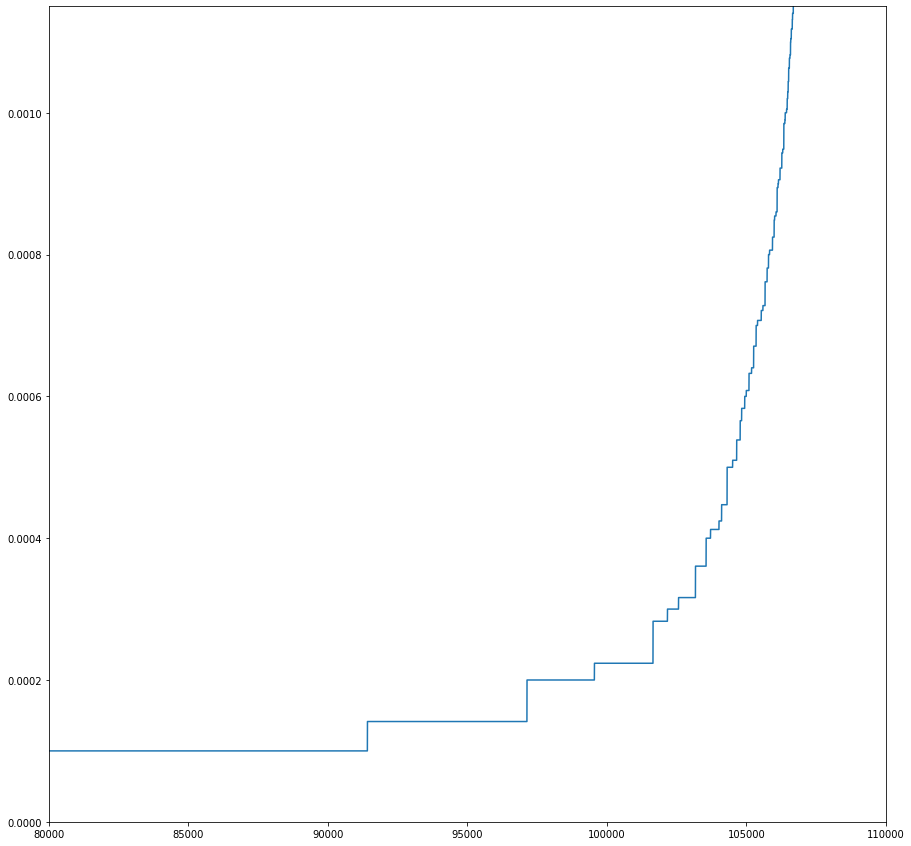

In [415]:
#Plotting esp curve to find most curving point
#The data was big, we had to zoom in.

f,ax = plt.subplots(figsize=(15,15))
distances_dbscan = np.sort(distances_dbscan, axis=0)
distances_dbscan = distances_dbscan[:,1]
ax.set(xlim=(80000, 110000), ylim=(0.0, 0.00115))
plt.plot(distances_dbscan)
plt.show()

I choose esp as esp=0.00022 according to graph. We should choose most elbow point.

2. Finding optimal min_samples parameter. First, let's find Silhouette method to find best coef and cluster. After, we will prove if this min_samples are good or not.

In [417]:
#K-Means to find best Silhouette score for Wednesday data.

#Converting to array
df_dbscan_wed=df_dbscan_wed.values

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10] #We skip 1.

for n_clusters in range_n_clusters:
    
    # Seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_dbscan_wed)

    # The silhouette_score:
    silhouette_avg = silhouette_score(df_dbscan_wed, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.7497117425420534
For n_clusters = 3 The average silhouette_score is : 0.42010438405033235
For n_clusters = 4 The average silhouette_score is : 0.4289467095379065
For n_clusters = 5 The average silhouette_score is : 0.4522118599687648
For n_clusters = 6 The average silhouette_score is : 0.47535223803080145
For n_clusters = 7 The average silhouette_score is : 0.4791462471120093
For n_clusters = 8 The average silhouette_score is : 0.43687164397102424
For n_clusters = 9 The average silhouette_score is : 0.38414129845501094
For n_clusters = 10 The average silhouette_score is : 0.3940715800362699


It seems cluster 6 or 7 works us best. 

I use OPTCIS algorithm to prove that we use optimal min_samples according to : https://medium.com/@mohantysandip/a-step-by-step-approach-to-solve-dbscan-algorithms-by-tuning-its-hyper-parameters-93e693a91289
**Ordering points to identify the clustering structure (OPTICS) is an algorithm for finding density-based clusters in spatial data.**

In [486]:
#Using Optical algorithm

clust= OPTICS(min_samples=10000, xi=0.5, min_cluster_size=0.1)
df_dbscan=df_dbscan_wed

#Run the fit
clust.fit(df_dbscan)
plt.figure(figsize=(10,7))
G=gridspec.GridSpec(2,3)
ax2=plt.subplot(G[1,0])

#Optics Algorithm to find the automated clusters
colors=['#CE4A7EFF','blue','green','#B0BFED','#008C76FF','#FC766AFF', 'white']
for klass, color in zip(range(0,7), colors):
    df_clusters=df_dbscan[clust.labels_ == klass]
    ax2.plot(df_dbscan_cluster[:,0], db_dbscan_clusters[:,1], color, alpha=0.3)
ax2.plot(df_dbscan[clust.labels_ ==-1, 0], df_dbscan[clust.labels_ == -1,1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering/n OPTICS')

plt.tight_layout()
Plt.show()

NameError: name 'gridspec' is not defined

<Figure size 720x504 with 0 Axes>

It is not working. too slow

Let's use these parameters for DBSCAN as esp=0.00022, min_samples=10000

Let's plot these clusters on map.

In [532]:
# #Mask for data 0h
# df_0_h=uber_df[(uber_df['DayOfWeek']=='Wednesday') & (uber_df['HourOfDay']==0)][['Lat','Lon']]
# lat_0=df_0_h["Lat"]
# lon_0=df_0_h["Lon"]
df_dbscan_wed.shape

(108631, 2)

In [448]:
#Let's cluster with DBSCAN

db_wed_0 = DBSCAN(eps = 0.00028, min_samples = 20, algorithm='ball_tree', metric='haversine')
db_wed_0.fit(np.radians(df_dbscan_wed))

#Num of cluster
cluster_labels = db_wed_0.labels_
num_clusters = len(set(cluster_labels))

In [450]:
print(num_clusters)

6


We got 6 clusters, like K-means. Now let's see density on map.

In [453]:
dbscan_predict = db_wed_0.fit_predict(df_dbscan_wed)

In [479]:
# DBSCAN
#Ploting the 6 clusters and classes from prediction on map Wednesday

color_u=['#CE4A7EFF','blue','yellow','cyan','#008C76FF','#FC766AFF']

#Initiliazing map
folium_map_0=folium.Map(location=[40.767937,-73.982155 ],tiles='cartodbdark_matter', zoom_start=14)

for i in range(num_clusters):
    for j in range(len(df_dbscan_wed[dbscan_predict == i])):
        folium.CircleMarker([df_dbscan_wed['Lat'][dbscan_predict == i].iloc[j], df_dbscan_wed['Lon'][dbscan_predict == i].iloc[j]],
                            radius=3,
                            color=color_u[i],
                            fill=True
                            ).add_to(folium_map_0)

folium_map_0.save("DBSCAN_Wed.html")
folium_map_0


It seems very logical, because at center of Manhattan, density seems high along big BLVDs.

(Next step: see the outliers.)

# 3.1 Lyft data clustering with K-Means

Let's do same thing with Lyft data. Wednesday trip plot in K-Means.

In [531]:
#Mask for data Wed
df_lyft_wed=pd.DataFrame(lyft_df[lyft_df['DayOfWeek']=='Wednesday'][['Lat','Lon']])
df_lyft_wed.shape

(30585, 2)

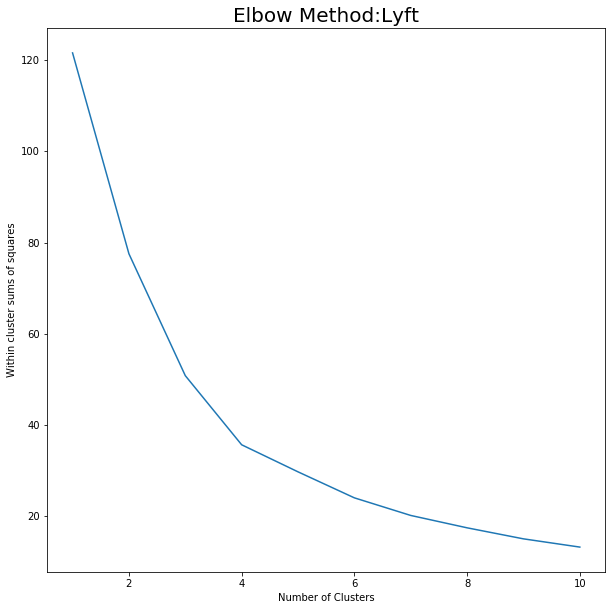

In [511]:
#Let's find cluster number from Elbow method

within_cluster_sums_of_squares_lyft = []

for i in range(1, 11):
    km_lyft = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km_lyft.fit(df_lyft_wed)
    within_cluster_sums_of_squares_lyft.append(km_lyft.inertia_)

f,ax = plt.subplots(figsize=(10,10))
# ax.set(xlim=(0, 10), ylim=(240, 2100))
plt.plot(range(1, 11), within_cluster_sums_of_squares_lyft)
plt.title('Elbow Method:Lyft', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('Within cluster sums of squares')
plt.show()

In [512]:
#K-Means to find best Silhouette score for Wednesday data.

#Converting to array
df_score_wed=df_lyft_wed.values

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10] #We skip 1.

for n_clusters in range_n_clusters:
    
    # Seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_score_wed)

    # The silhouette_score:
    silhouette_avg = silhouette_score(df_score_wed, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average Lyft data silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average Lyft data silhouette_score is : 0.4877138449509729
For n_clusters = 3 The average Lyft data silhouette_score is : 0.4888005364910977
For n_clusters = 4 The average Lyft data silhouette_score is : 0.4655887381839275
For n_clusters = 5 The average Lyft data silhouette_score is : 0.45831991075870815
For n_clusters = 6 The average Lyft data silhouette_score is : 0.40451404655290624
For n_clusters = 7 The average Lyft data silhouette_score is : 0.4133720683910082
For n_clusters = 8 The average Lyft data silhouette_score is : 0.41057368460137117
For n_clusters = 9 The average Lyft data silhouette_score is : 0.3930673249453077
For n_clusters = 10 The average Lyft data silhouette_score is : 0.40917620397820265


Let's use 6 clusters.

In [526]:
#Mask for data Wed
df_lyft_wed=pd.DataFrame(lyft_df[lyft_df['DayOfWeek']=='Wednesday'][['Lat','Lon']])

In [527]:
#K-means for Wed Lyft
km_lyft_wed = KMeans(n_clusters = 6, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0).fit(df_lyft_wed)

#Find y
y_lyft_wed = km_lyft_wed.fit_predict(df_lyft_wed)
#Centroids
centroids_wed=km_lyft_wed.cluster_centers_

In [528]:
centroids_wed

array([[ 40.63188762, -73.97533937],
       [ 40.69392536, -73.94511282],
       [ 40.72885088, -73.99423693],
       [ 40.8030374 , -73.90971813],
       [ 40.7005154 , -73.8131525 ],
       [ 40.76420705, -73.97245406]])

In [529]:
# Ploting the 6 clusters and classes from prediction on map on Wednesday

color_u=['#CE4A7EFF','blue','yellow','cyan','#008C76FF','#FC766AFF']

folium_map_km=folium.Map(location=[40.767937,-73.982155 ],tiles='cartodbdark_matter', zoom_start=12)

for i in range(len(centroids_wed)):
    for j in range(len(df_lyft_wed[y_lyft_wed == i])):
        folium.CircleMarker([df_lyft_wed['Lat'][y_lyft_wed == i].iloc[j], df_lyft_wed['Lon'][y_lyft_wed == i].iloc[j]],
                            radius=3,
                            color=color_u[i],
                            fill=True
                            ).add_to(folium_map_km)

#Plotting Centroid points on map
for k in range(len(centroids_wed)):
        folium.CircleMarker(centroids_wed[k],
                            radius=9,
                            color='red',
                            fill_color='red',
                            fill=True
                            ).add_to(folium_map_km)
#Saving the data        
folium_map_km.save("Lyft_KMeans_Wed.html")
